# **Wind & Solar Energy Production Analysis 🏭☀️🌬️**

## **Introduction**

The global transition to renewable energy has made **Wind and Solar power** critical components of modern energy grids. Understanding the patterns, reliability, and variability of renewable energy production is essential for:

- **Grid optimization**  
- **Energy storage planning**  
- **Hybrid system design**  
- **Policy and capacity planning**

This notebook presents a **comprehensive Exploratory Data Analysis (EDA)** on a Wind & Solar Energy Production dataset. The goal is to uncover **temporal trends, source-specific characteristics, seasonal and hourly patterns, statistical insights, and operational recommendations**. 

The analysis is divided into seven key sections:

1️⃣ **Temporal (Time-Based) Insights**  
   - Explore daily, hourly, weekly, and monthly production trends.  
   - Identify peak production hours, low-production periods, and cyclic patterns.  
   - Insights are useful for **load balancing and forecasting**.

2️⃣ **Source-Based Comparison (Wind vs Solar)**  
   - Compare production distribution, variance, and stability.  
   - Analyze reliability, frequency of near-zero production, and complementarity between Wind and Solar.  
   - Highlights **system-level thinking for hybrid energy planning**.

3️⃣ **Seasonal & Weather-Driven Insights**  
   - Assess production trends across seasons and months.  
   - Identify transitional months and seasonal volatility.  
   - Useful for **capacity planning and strategic energy management**.

4️⃣ **Hour-Level Granular Analysis**  
   - Investigate intra-day production curves and peak timings.  
   - Validate **Start_Hour vs End_Hour consistency** to ensure data integrity.  
   - Provides **high-resolution operational insights**.

5️⃣ **Statistical Insights**  
   - Quantify **variability, stability, and predictability** using Coefficient of Variation (CV).  
   - Detect **outliers** and explore skewness & kurtosis of production distributions.  
   - Adds **professional-level statistical depth** to the analysis.

6️⃣ **Energy Planning & Policy Insights**  
   - Identify periods of underutilized capacity and ideal time windows for battery charging.  
   - Highlight high uncertainty and low reliability periods.  
   - Suggest hybrid energy strategies for **executive-level decision making**.

7️⃣ **Data Quality & Integrity Checks**  
   - Detect duplicate timestamps, missing time continuity, and impossible values (e.g., negative production, Solar at night).  
   - Ensure **date parsing and data consistency**.  
   - Demonstrates **real-world data science rigor**.

---

> This analysis aims to combine **data science rigor, domain knowledge, and actionable insights** to provide a **holistic understanding of Wind and Solar energy production**.  
> The results can inform **grid operators, energy planners, and policy makers** while serving as a **professional-grade example of EDA in renewable energy analytics**.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
sns.set_style('dark')
plt.style.use('dark_background')
plt.rcParams['figure.figsize'] = (14,6)

In [4]:
df = pd.read_csv("/kaggle/input/wind-and-solar-energy-production-dataset/Energy Production Dataset.csv")

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51864 entries, 0 to 51863
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Date         51864 non-null  object
 1   Start_Hour   51864 non-null  int64 
 2   End_Hour     51864 non-null  int64 
 3   Source       51864 non-null  object
 4   Day_of_Year  51864 non-null  int64 
 5   Day_Name     51864 non-null  object
 6   Month_Name   51864 non-null  object
 7   Season       51864 non-null  object
 8   Production   51864 non-null  int64 
dtypes: int64(4), object(5)
memory usage: 3.6+ MB


In [6]:
# Ensure Date column is datetime
df['Date'] = pd.to_datetime(df['Date'])

# Create additional useful columns
df['Hour_Midpoint'] = (df['Start_Hour'] + df['End_Hour']) / 2  # For smoother hourly analysis
df['Weekday'] = df['Date'].dt.day_name()
df['Month'] = df['Date'].dt.month_name()
df['Day_of_Year'] = df['Date'].dt.dayofyear

# **1️⃣ Temporal (Time-Based) Insights ⭐**

### **1️⃣ Hourly Production Patterns**

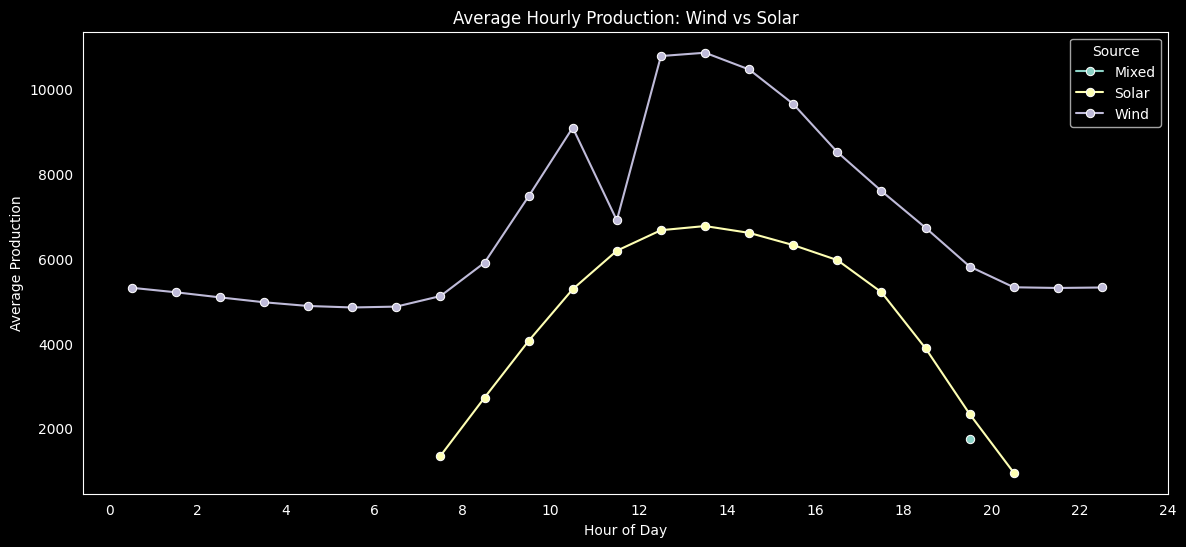

In [7]:
# Group by Source and Hour
hourly = df.groupby(['Source','Hour_Midpoint'])['Production'].mean().reset_index()

# Plot
sns.lineplot(data=hourly, x='Hour_Midpoint', y='Production', hue='Source', marker='o')
plt.title("Average Hourly Production: Wind vs Solar")
plt.xlabel("Hour of Day")
plt.ylabel("Average Production")
plt.xticks(range(0,25,2))
plt.show()


#### **Morning vs Afternoon vs Evening**

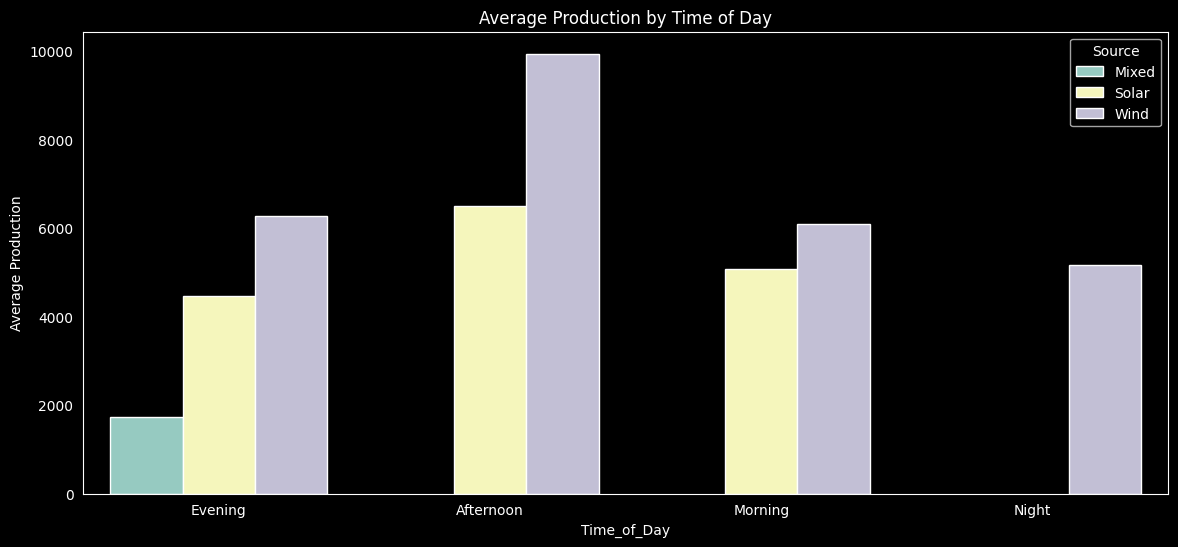

In [8]:
# Create time-of-day bins
def time_of_day(hour):
    if 5 <= hour < 12:
        return 'Morning'
    elif 12 <= hour < 17:
        return 'Afternoon'
    elif 17 <= hour < 21:
        return 'Evening'
    else:
        return 'Night'

df['Time_of_Day'] = df['Hour_Midpoint'].apply(time_of_day)

# Group by Source & Time_of_Day
tod = df.groupby(['Source','Time_of_Day'])['Production'].mean().reset_index()

sns.barplot(data=tod, x='Time_of_Day', y='Production', hue='Source')
plt.title("Average Production by Time of Day")
plt.ylabel("Average Production")
plt.show()


### **2️⃣ Day of Week Analysis**

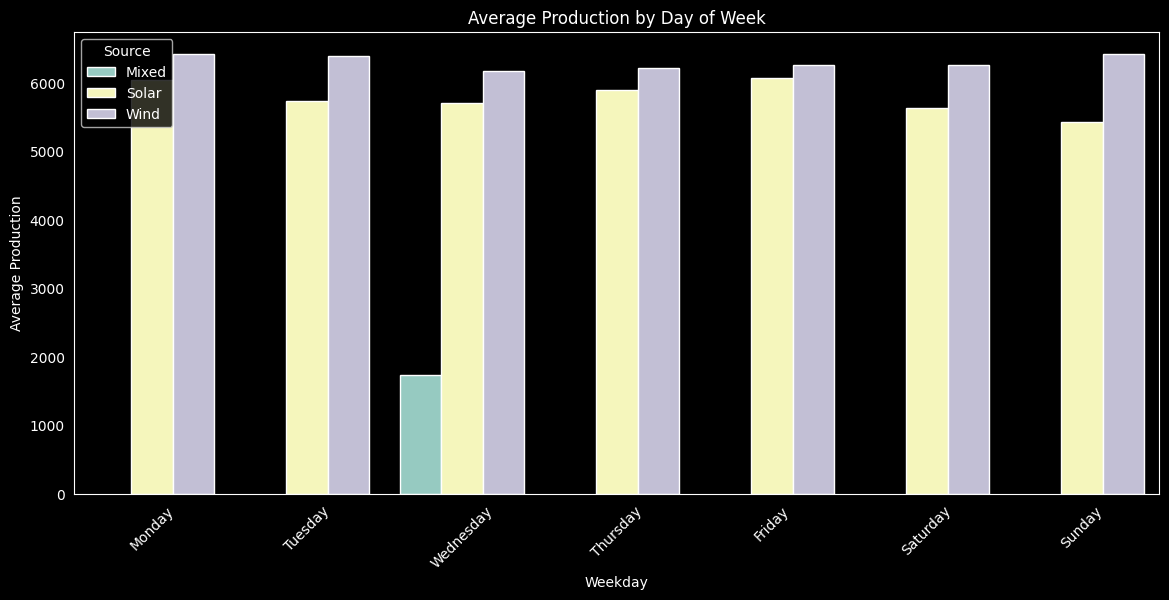

In [9]:
# Make Weekday a categorical column with correct order
weekday_order = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
df['Weekday'] = pd.Categorical(df['Weekday'], categories=weekday_order, ordered=True)

# Group by Source & Weekday
dow = df.groupby(['Source','Weekday'], as_index=False)['Production'].mean()

# Plot
sns.barplot(data=dow, x='Weekday', y='Production', hue='Source')
plt.title("Average Production by Day of Week")
plt.ylabel("Average Production")
plt.xticks(rotation=45)
plt.show()


### **3️⃣ Monthly Trends**

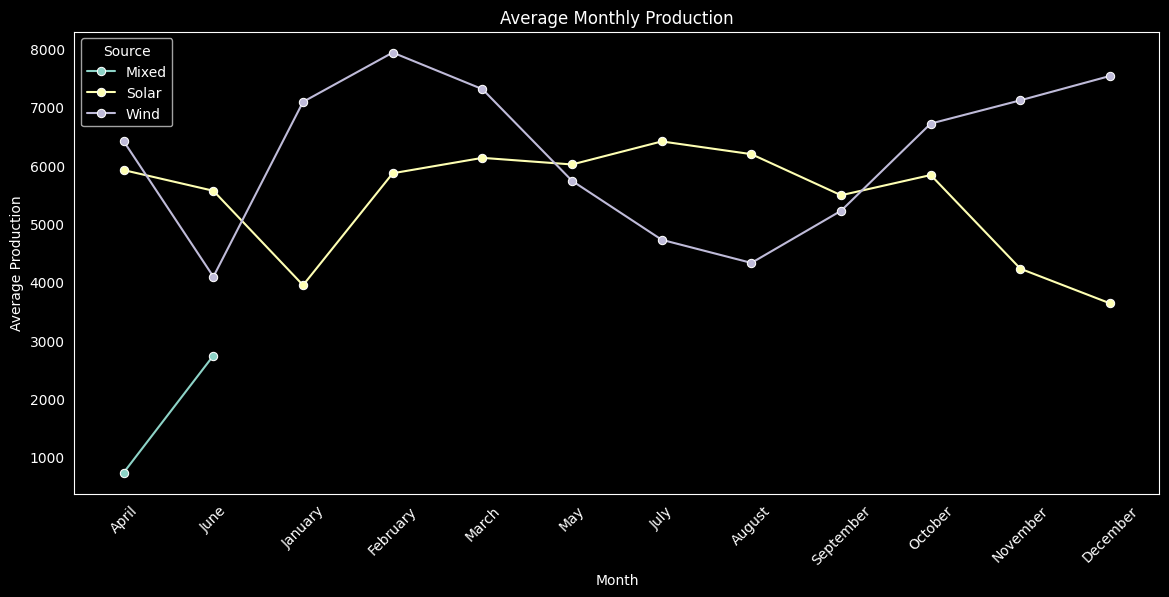

In [10]:
# Average production by month
month_order = ['January','February','March','April','May','June','July','August','September','October','November','December']
monthly = df.groupby(['Source','Month'])['Production'].mean().reindex(month_order, level=1).reset_index()

sns.lineplot(data=monthly, x='Month', y='Production', hue='Source', marker='o')
plt.title("Average Monthly Production")
plt.ylabel("Average Production")
plt.xticks(rotation=45)
plt.show()


### **4️⃣ Day of Year Continuity (Rolling Average)**

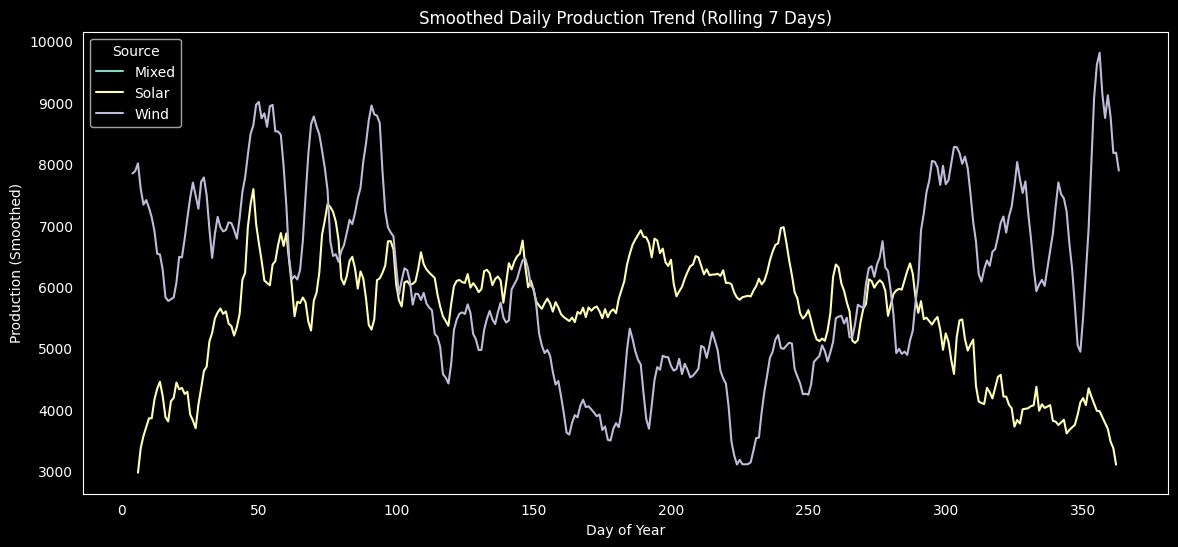

In [11]:
# Smooth trend using 7-day rolling average
df_sorted = df.sort_values('Date')
rolling = df_sorted.groupby(['Source','Day_of_Year'])['Production'].mean().reset_index()
rolling['Production_Smooth'] = rolling.groupby('Source')['Production'].transform(lambda x: x.rolling(7, center=True).mean())

sns.lineplot(data=rolling, x='Day_of_Year', y='Production_Smooth', hue='Source')
plt.title("Smoothed Daily Production Trend (Rolling 7 Days)")
plt.xlabel("Day of Year")
plt.ylabel("Production (Smoothed)")
plt.show()


# **2️⃣ Source-Based Comparison (Wind vs Solar) 🔥**

In [12]:
# Pivot the data so that we have one row per Date & Hour, and separate columns for Wind & Solar
df_pivot = df.pivot_table(index=['Date','Start_Hour','End_Hour'], 
                          columns='Source', 
                          values='Production').reset_index()

# Fill NaNs with 0 (if one source was missing at a particular time)
df_pivot.fillna(0, inplace=True)

df_pivot.head()


Source,Date,Start_Hour,End_Hour,Mixed,Solar,Wind
0,2020-01-01,0,1,0.0,0.0,3542.0
1,2020-01-01,1,2,0.0,0.0,2932.0
2,2020-01-01,2,3,0.0,0.0,2725.0
3,2020-01-01,3,4,0.0,0.0,2761.0
4,2020-01-01,4,5,0.0,0.0,2708.0


### **1️⃣ Production Distribution**

**We will compare mean, median, variance, and skewness for both sources.**

In [13]:
sources = ['Solar','Wind']
for s in sources:
    mean = df_pivot[s].mean()
    median = df_pivot[s].median()
    var = df_pivot[s].var()
    skew = stats.skew(df_pivot[s])
    print(f"{s} -> Mean: {mean:.2f}, Median: {median:.2f}, Variance: {var:.2f}, Skewness: {skew:.2f}")


Solar -> Mean: 1047.76, Median: 0.00, Variance: 6025429.62, Skewness: 2.36
Wind -> Mean: 5167.08, Median: 4113.50, Variance: 20629455.54, Skewness: 0.86


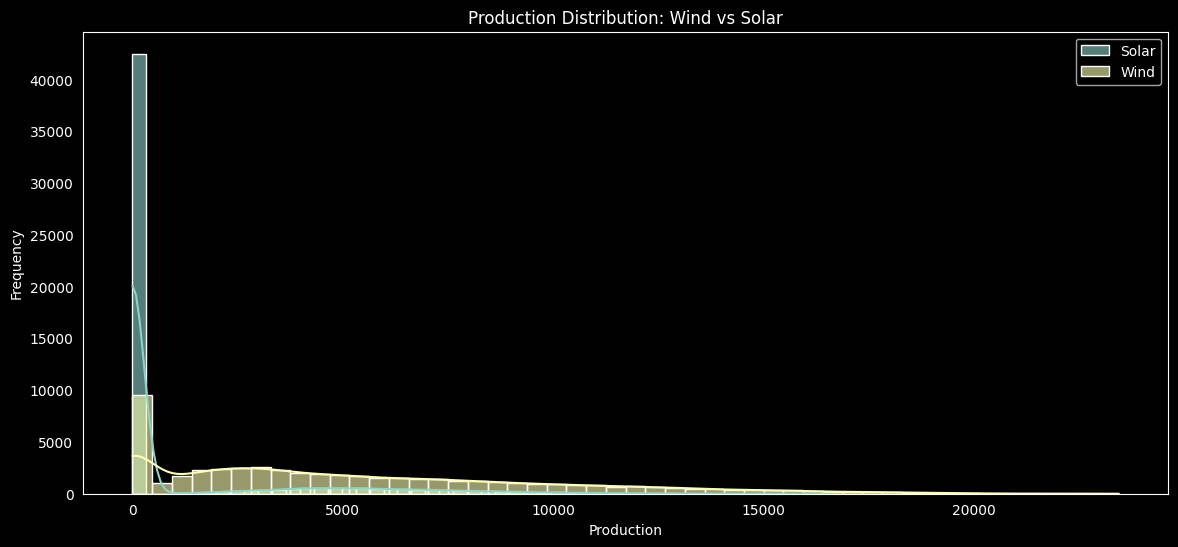

In [14]:
plt.figure(figsize=(14,6))
for s in sources:
    sns.histplot(df_pivot[s], kde=True, label=s, bins=50, alpha=0.6)
plt.title("Production Distribution: Wind vs Solar")
plt.xlabel("Production")
plt.ylabel("Frequency")
plt.legend()
plt.show()


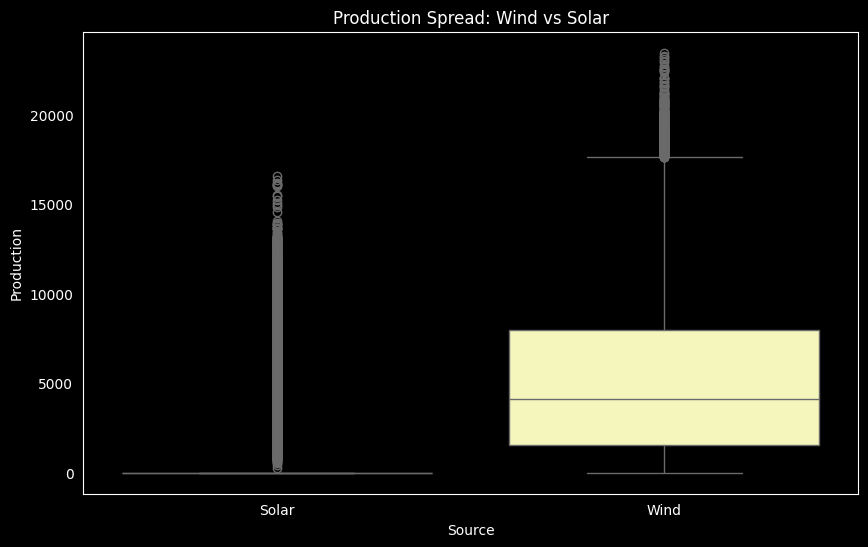

In [15]:
plt.figure(figsize=(10,6))
sns.boxplot(data=df_pivot[sources])
plt.title("Production Spread: Wind vs Solar")
plt.ylabel("Production")
plt.show()

### **2️⃣ Reliability Analysis: Near-Zero Production**

In [16]:
threshold = 0.05 * df_pivot[sources].max().max()  # 5% of max production
near_zero = (df_pivot[sources] < threshold).sum()
print("Near-zero Production Counts:")
print(near_zero)

Near-zero Production Counts:
Source
Solar    42532
Wind     11426
dtype: int64


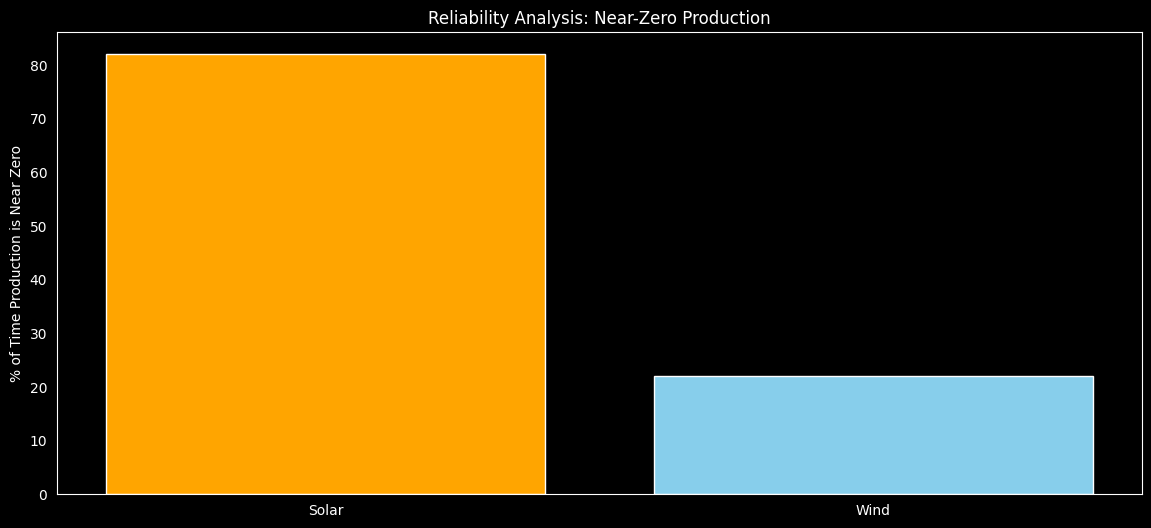

In [17]:
percent_zero = (df_pivot[sources] < threshold).mean() * 100
plt.bar(percent_zero.index, percent_zero.values, color=['orange','skyblue'])
plt.ylabel("% of Time Production is Near Zero")
plt.title("Reliability Analysis: Near-Zero Production")
plt.show()


### **3️⃣ Complementarity Analysis (Wind & Solar Together)**

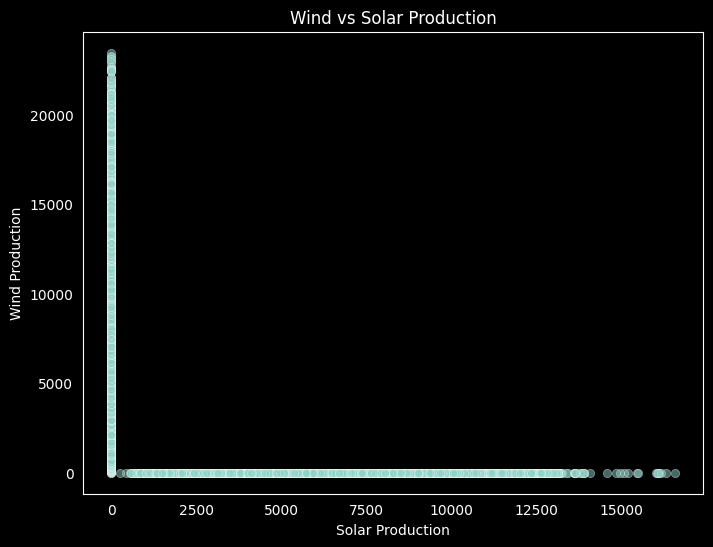

In [18]:
plt.figure(figsize=(8,6))
sns.scatterplot(x='Solar', y='Wind', data=df_pivot, alpha=0.5)
plt.title("Wind vs Solar Production")
plt.xlabel("Solar Production")
plt.ylabel("Wind Production")
plt.show()


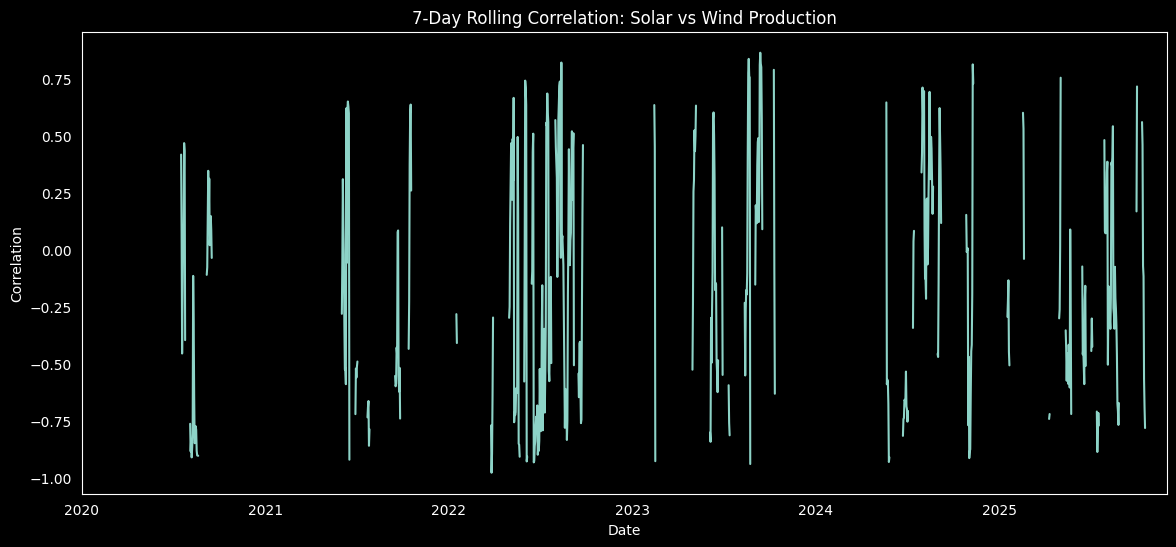

In [19]:
# Daily sum of production
daily = df.groupby(['Date','Source'])['Production'].sum().reset_index()
daily_pivot = daily.pivot(index='Date', columns='Source', values='Production')

# 7-day rolling correlation
daily_pivot['rolling_corr'] = daily_pivot['Solar'].rolling(7).corr(daily_pivot['Wind'])

plt.figure(figsize=(14,6))
daily_pivot['rolling_corr'].plot()
plt.title("7-Day Rolling Correlation: Solar vs Wind Production")
plt.ylabel("Correlation")
plt.xlabel("Date")
plt.show()


# **3️⃣ Seasonal & Weather-Driven Insights 🌦️**

In [20]:
month_order = ['January','February','March','April','May','June','July','August','September','October','November','December']
season_order = ['Winter','Spring','Summer','Autumn']  # adjust based on your data

df['Month_Name'] = pd.Categorical(df['Month_Name'], categories=month_order, ordered=True)
df['Season'] = pd.Categorical(df['Season'], categories=season_order, ordered=True)

### **1️⃣ Season-wise Production: Mean & Volatility**

#### **Calculate stats per Source & Season**

In [21]:
season_stats = df.groupby(['Source','Season'])['Production'].agg(['mean','std']).reset_index()
season_stats.rename(columns={'std':'volatility'}, inplace=True)
season_stats


,Source,Season,mean,volatility
0,Mixed,Winter,NaN,NaN
1,Mixed,Spring,734.000000,NaN
2,Mixed,Summer,2740.000000,NaN
3,Mixed,Autumn,NaN,NaN
4,Solar,Winter,4649.541547,1996.051987
5,Solar,Spring,6009.738123,2440.833148
6,Solar,Summer,6044.805369,2418.667444
7,Solar,Autumn,NaN,NaN
8,Wind,Winter,7504.270275,4599.198881
9,Wind,Spring,6525.051057,3974.388910


#### **Plot: Mean Production by Season**

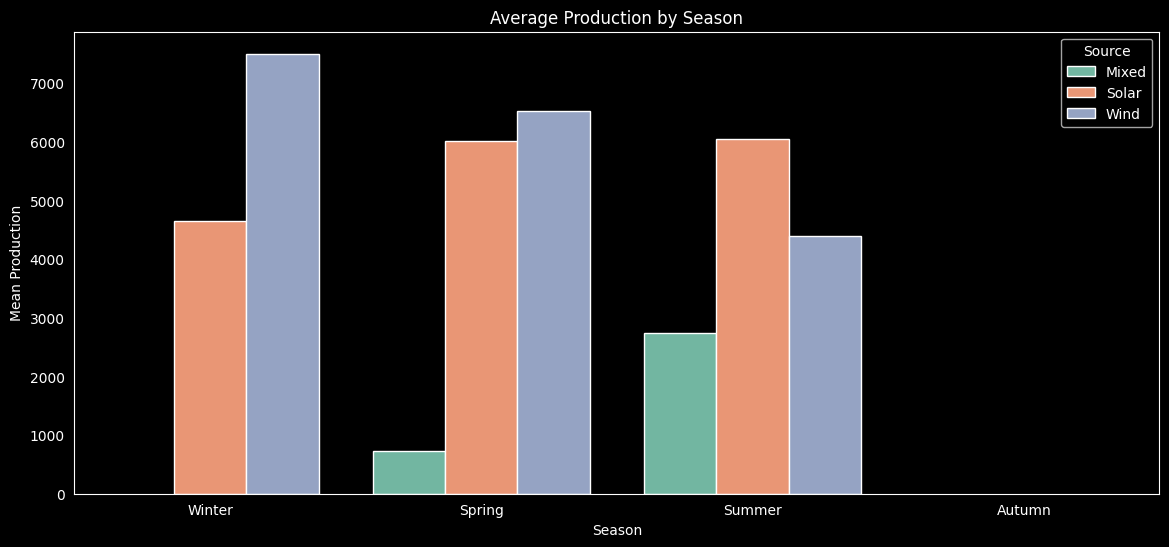

In [22]:
sns.barplot(data=season_stats, x='Season', y='mean', hue='Source', palette='Set2')
plt.title("Average Production by Season")
plt.ylabel("Mean Production")
plt.show()


#### **Plot: Volatility by Season**

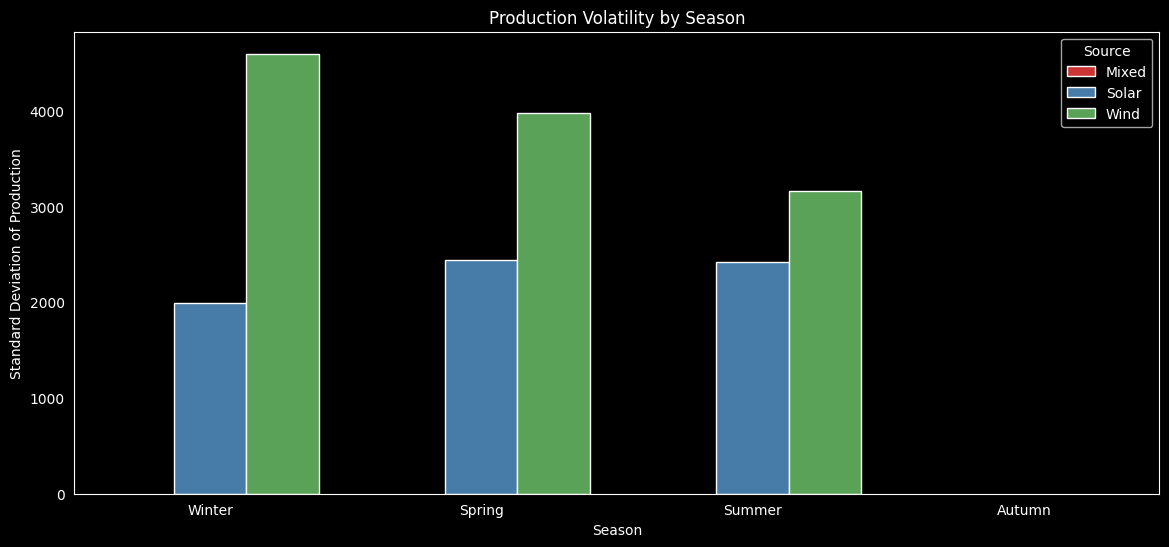

In [23]:
sns.barplot(data=season_stats, x='Season', y='volatility', hue='Source', palette='Set1')
plt.title("Production Volatility by Season")
plt.ylabel("Standard Deviation of Production")
plt.show()

### **2️⃣ Season × Source Interaction Heatmap**

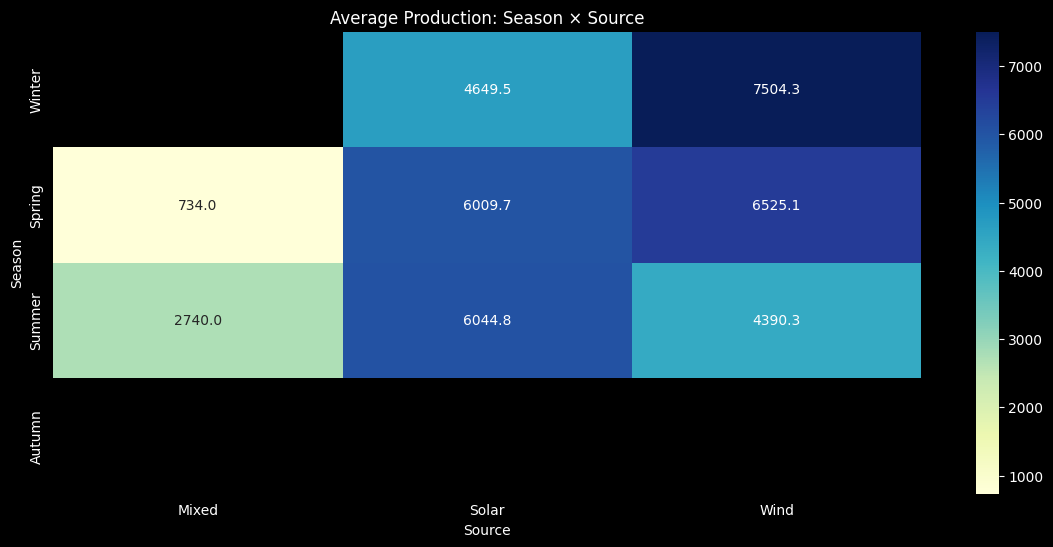

In [24]:
interaction = df.groupby(['Season','Source'])['Production'].mean().unstack()

sns.heatmap(interaction, annot=True, fmt=".1f", cmap="YlGnBu")
plt.title("Average Production: Season × Source")
plt.ylabel("Season")
plt.show()


### **3️⃣ Month–Season Cross Analysis**

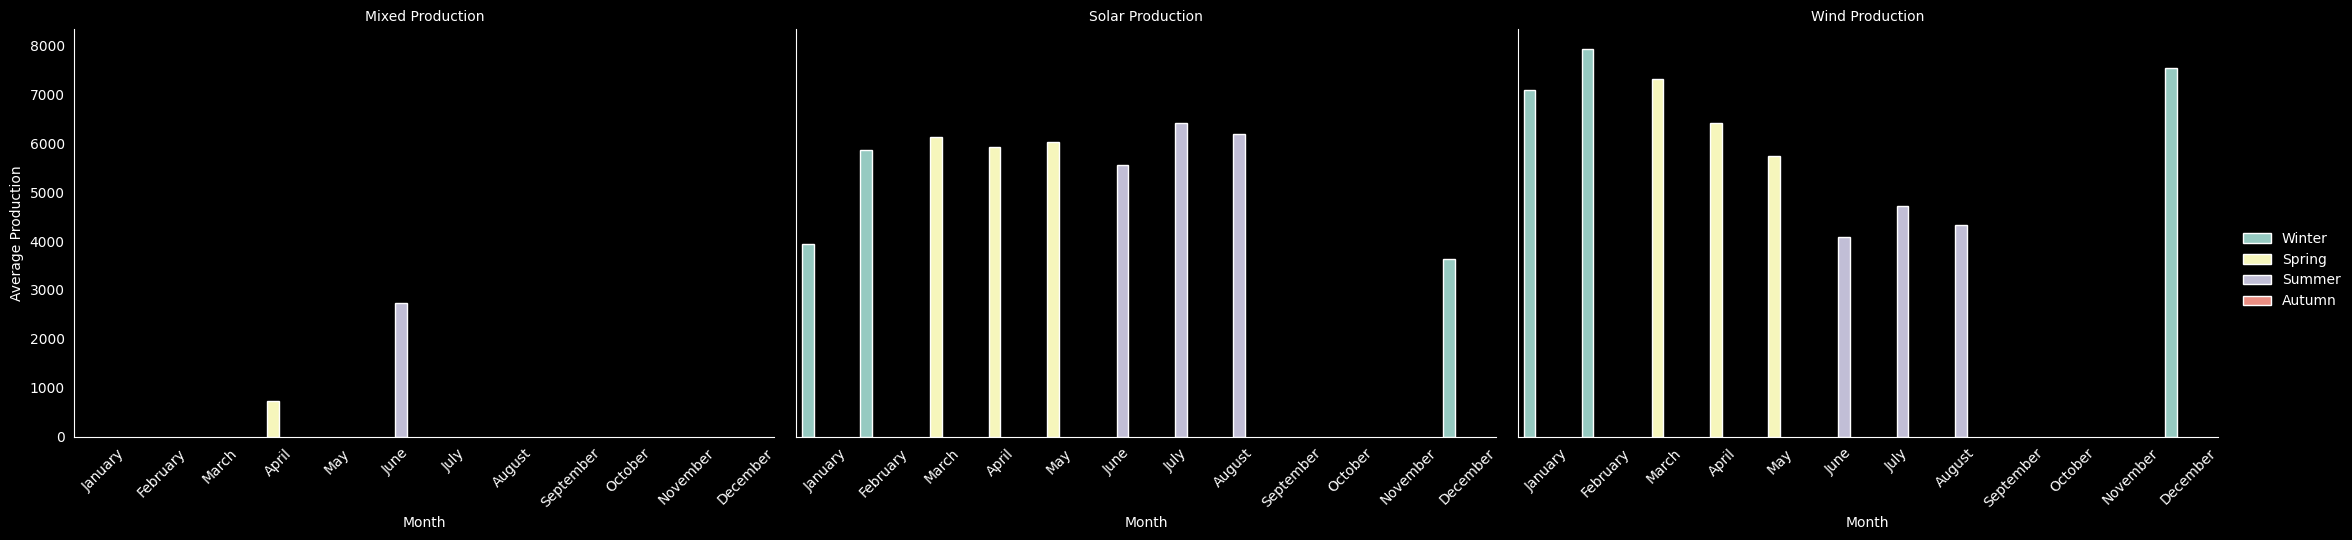

In [25]:
month_season = df.groupby(['Month_Name','Season','Source'])['Production'].mean().reset_index()

# FacetGrid by Source
g = sns.FacetGrid(month_season, col="Source", height=5, aspect=1.5)
g.map_dataframe(sns.barplot, x="Month_Name", y="Production", hue="Season", palette="Set3")
g.set_xticklabels(rotation=45)
g.set_titles("{col_name} Production")
g.set_axis_labels("Month", "Average Production")
g.add_legend()
plt.show()


### **4️⃣ Seasonal Trend Lines Across Year**

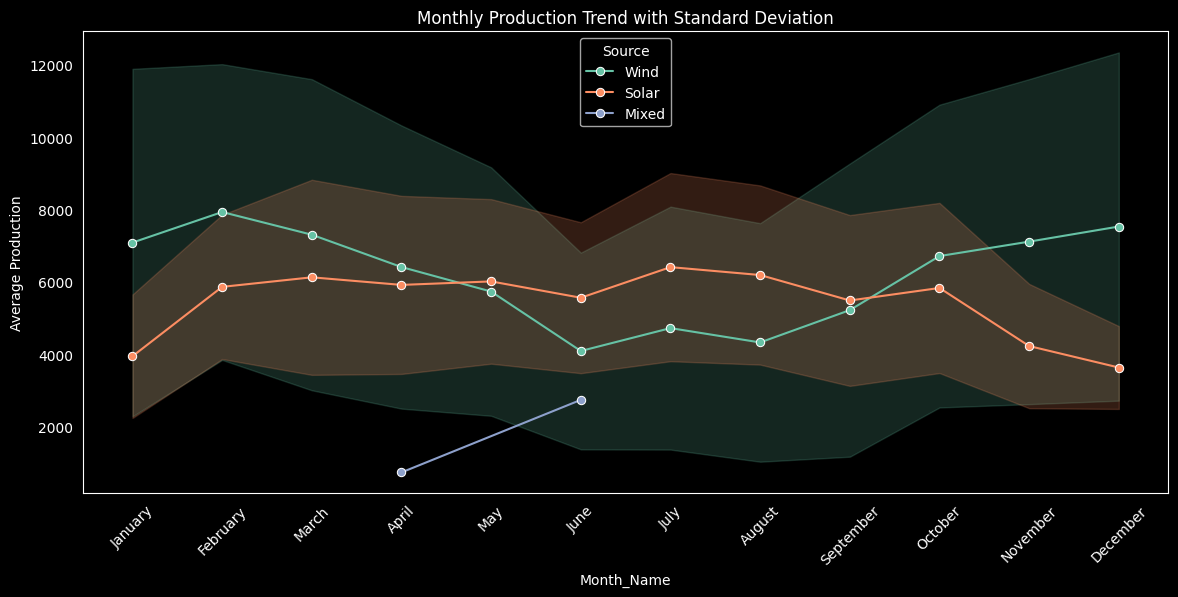

In [26]:
sns.lineplot(data=df, x='Month_Name', y='Production', hue='Source', ci='sd', marker='o', palette='Set2')
plt.title("Monthly Production Trend with Standard Deviation")
plt.ylabel("Average Production")
plt.xticks(rotation=45)
plt.show()


# **4️⃣ Hour-Level Granular Analysis ⏰ (Advanced)**

In [27]:
# Create a column for Hour Midpoint for smooth plotting
df['Hour_Midpoint'] = (df['Start_Hour'] + df['End_Hour']) / 2

### **1️⃣ Intra-day Production Curves**

#### **Average Production per Hour for Each Source**

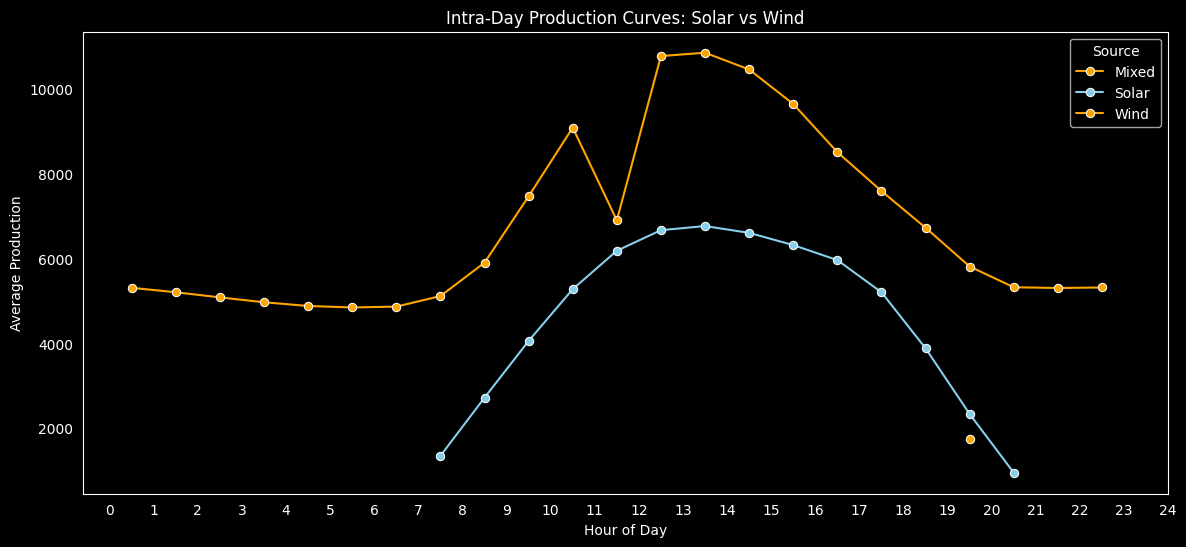

In [28]:
hourly = df.groupby(['Source','Hour_Midpoint'])['Production'].mean().reset_index()

sns.lineplot(data=hourly, x='Hour_Midpoint', y='Production', hue='Source', marker='o', palette=['orange','skyblue'])
plt.title("Intra-Day Production Curves: Solar vs Wind")
plt.xlabel("Hour of Day")
plt.ylabel("Average Production")
plt.xticks(range(0,25,1))
plt.show()


### **2️⃣ Start_Hour vs End_Hour Consistency**

#### **We want to check duration correctness and possible overlaps.**

#### Step 1: Duration Distribution

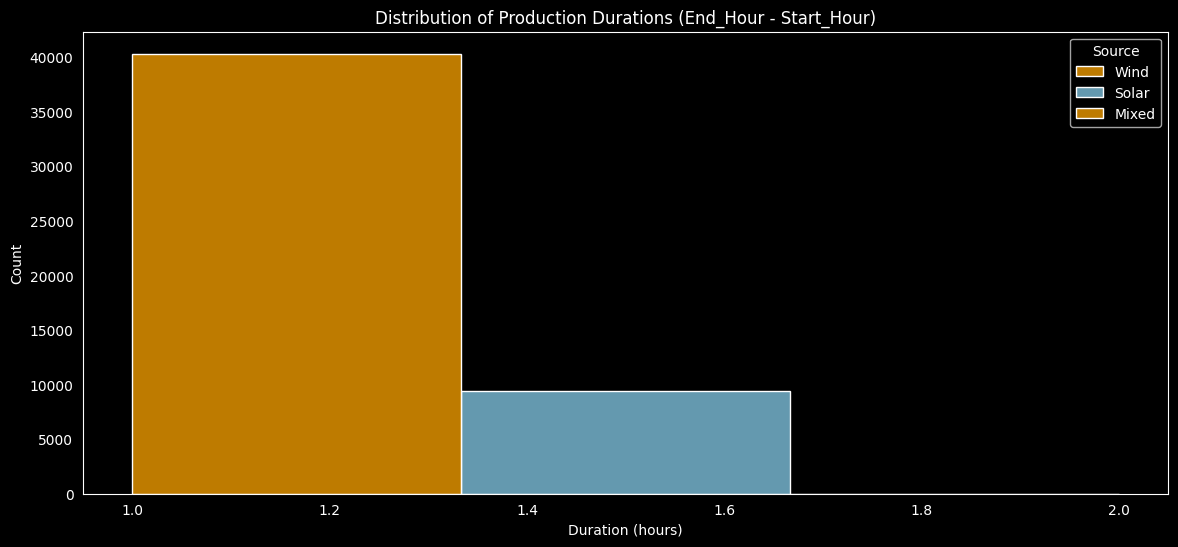

In [29]:
df['Duration'] = df['End_Hour'] - df['Start_Hour']

sns.histplot(data=df, x='Duration', bins=range(1, df['Duration'].max()+2), hue='Source', multiple='dodge', palette=['orange','skyblue'])
plt.title("Distribution of Production Durations (End_Hour - Start_Hour)")
plt.xlabel("Duration (hours)")
plt.ylabel("Count")
plt.show()


#### Step 2: Start_Hour vs End_Hour Scatter Plot

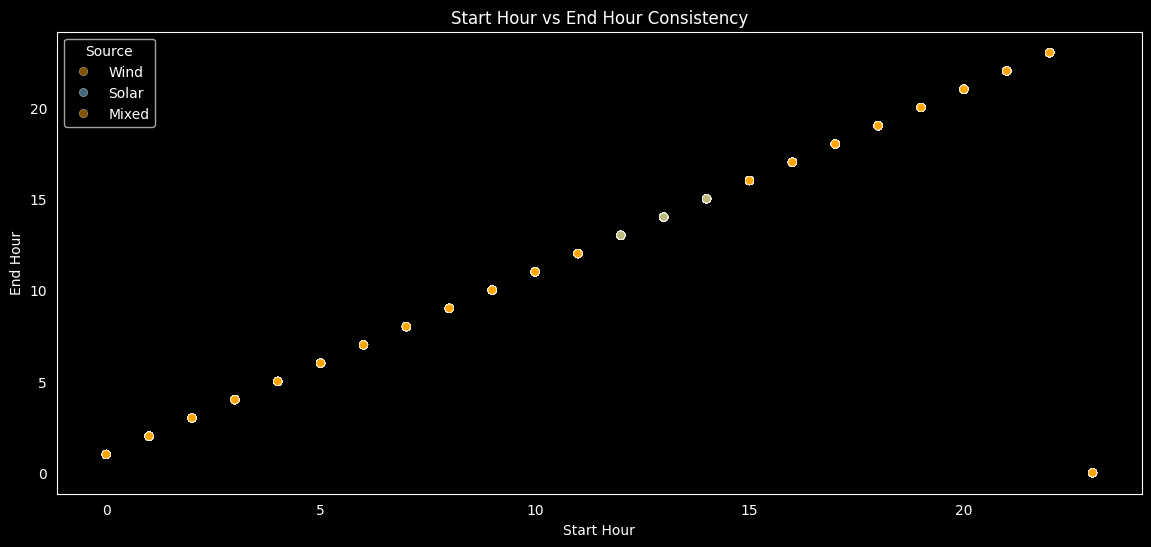

In [30]:
sns.scatterplot(data=df, x='Start_Hour', y='End_Hour', hue='Source', alpha=0.5, palette=['orange','skyblue'])
plt.title("Start Hour vs End Hour Consistency")
plt.xlabel("Start Hour")
plt.ylabel("End Hour")
plt.show()

#### Step 3 : Hourly Heatmap of Production Blocks

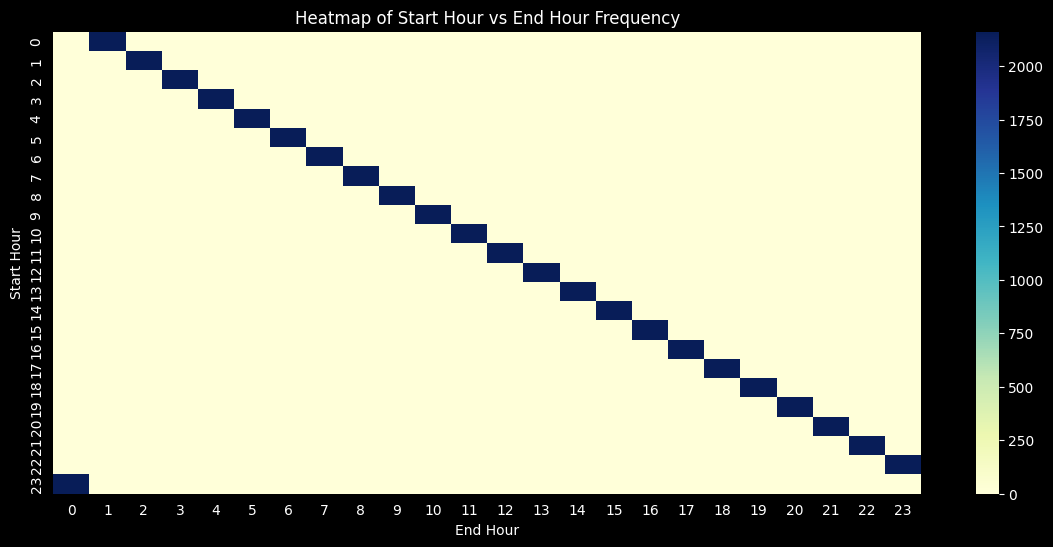

In [31]:
pivot = df.pivot_table(index='Start_Hour', columns='End_Hour', values='Production', aggfunc='count', fill_value=0)

sns.heatmap(pivot, cmap='YlGnBu')
plt.title("Heatmap of Start Hour vs End Hour Frequency")
plt.xlabel("End Hour")
plt.ylabel("Start Hour")
plt.show()


# **5️⃣ Statistical Insights 📊**

### **1️⃣ Variability & Stability: Coefficient of Variation**

In [32]:
cv = {}
for s in sources:
    mean = df_pivot[s].mean()
    std = df_pivot[s].std()
    cv[s] = std / mean

cv

{'Solar': np.float64(2.342785992609282),
 'Wind': np.float64(0.8790198890755493)}

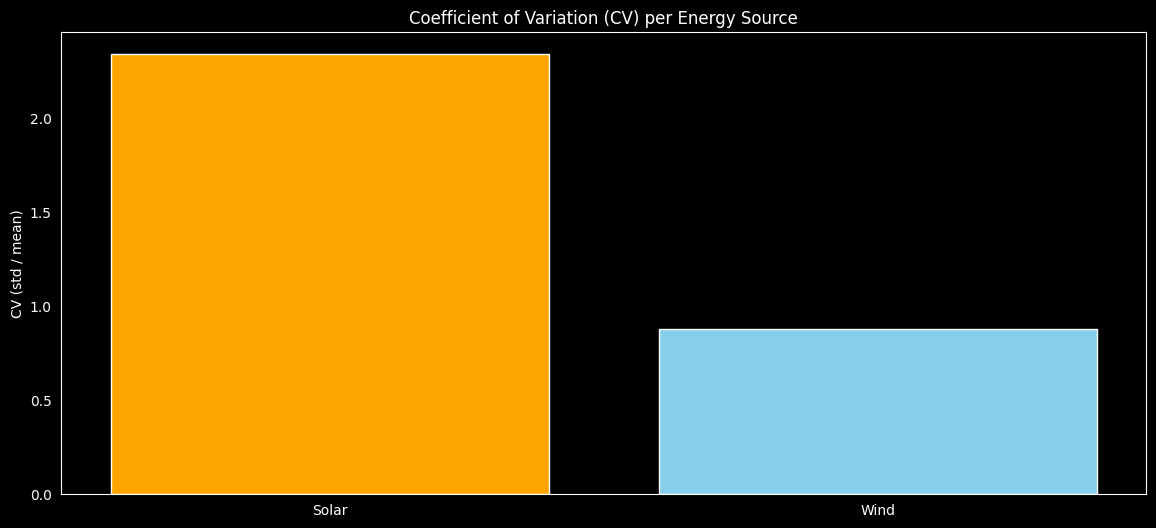

In [33]:
plt.bar(cv.keys(), cv.values(), color=['orange','skyblue'])
plt.title("Coefficient of Variation (CV) per Energy Source")
plt.ylabel("CV (std / mean)")
plt.show()


### **2️⃣ Outlier Detection**

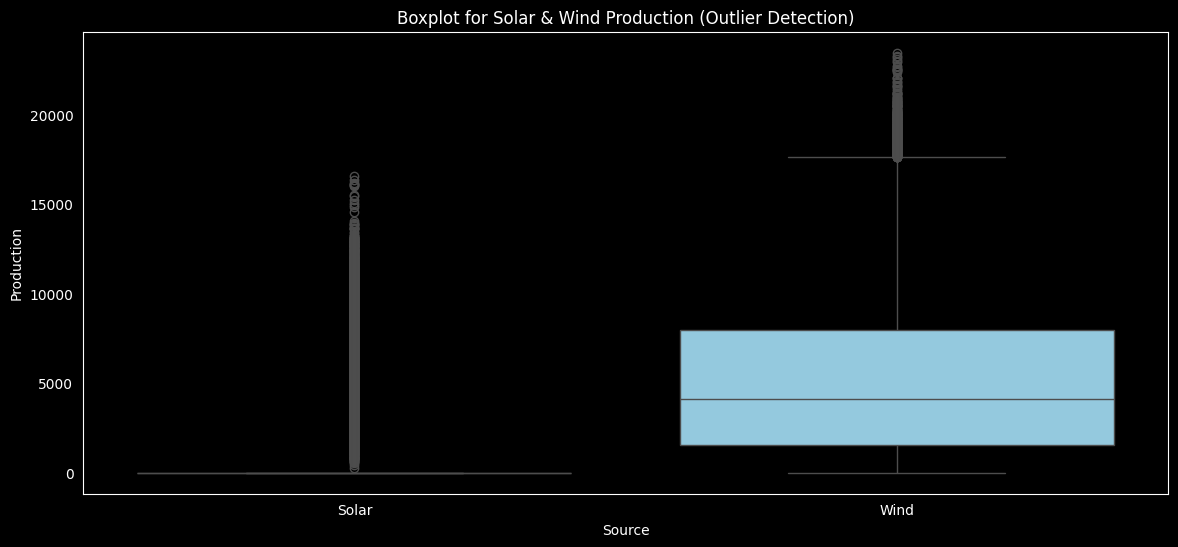

In [34]:
sns.boxplot(data=df_pivot[sources], palette=['orange','skyblue'])
plt.title("Boxplot for Solar & Wind Production (Outlier Detection)")
plt.ylabel("Production")
plt.show()


#### **Identify Top Outliers**

In [35]:
for s in sources:
    threshold = df_pivot[s].mean() + 3*df_pivot[s].std()
    outliers = df_pivot[df_pivot[s] > threshold]
    print(f"{s} Outliers: {len(outliers)} points")

Solar Outliers: 1396 points
Wind Outliers: 238 points


### **3️⃣ Skewness & Kurtosis**

In [36]:
for s in sources:
    skew = stats.skew(df_pivot[s])
    kurt = stats.kurtosis(df_pivot[s])
    print(f"{s}: Skewness = {skew:.2f}, Kurtosis = {kurt:.2f}")

Solar: Skewness = 2.36, Kurtosis = 4.80
Wind: Skewness = 0.86, Kurtosis = 0.11


#### **Plot Distribution with KDE**

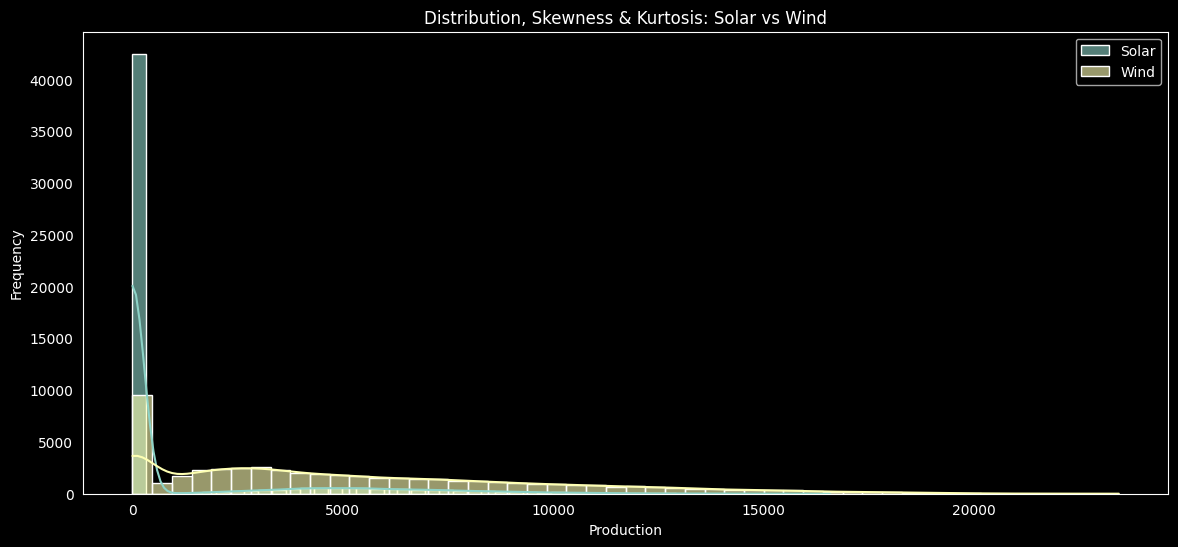

In [37]:
plt.figure(figsize=(14,6))
for s in sources:
    sns.histplot(df_pivot[s], kde=True, label=s, bins=50, alpha=0.6)
plt.title("Distribution, Skewness & Kurtosis: Solar vs Wind")
plt.xlabel("Production")
plt.ylabel("Frequency")
plt.legend()
plt.show()

# **6️⃣ Energy Planning & Policy Insights 🏗️**

In [38]:
df_pivot['Total_Production'] = df_pivot['Solar'] + df_pivot['Wind']

max_capacity = df_pivot[sources].max()
df_pivot['Solar_util'] = df_pivot['Solar'] / max_capacity['Solar'] * 100
df_pivot['Wind_util'] = df_pivot['Wind'] / max_capacity['Wind'] * 100
df_pivot['Total_util'] = df_pivot['Total_Production'] / (max_capacity['Solar'] + max_capacity['Wind']) * 100

### **1️⃣ Capacity Utilization Patterns**

#### **Step 1: Average Hourly Utilization**

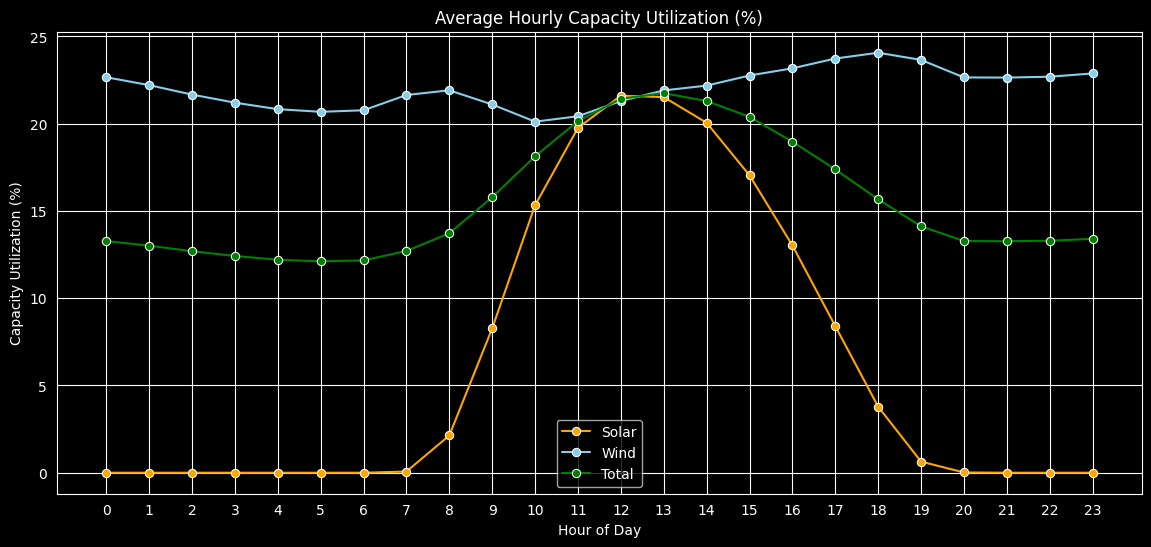

In [39]:
hourly_util = df_pivot.groupby('Start_Hour')[['Solar_util','Wind_util','Total_util']].mean().reset_index()

sns.lineplot(data=hourly_util, x='Start_Hour', y='Solar_util', label='Solar', color='orange', marker='o')
sns.lineplot(data=hourly_util, x='Start_Hour', y='Wind_util', label='Wind', color='skyblue', marker='o')
sns.lineplot(data=hourly_util, x='Start_Hour', y='Total_util', label='Total', color='green', marker='o')
plt.title("Average Hourly Capacity Utilization (%)")
plt.xlabel("Hour of Day")
plt.ylabel("Capacity Utilization (%)")
plt.xticks(range(0,24,1))
plt.grid(True)
plt.show()

#### **Step 2: Heatmap for Hour × Day-of-Year Utilization**

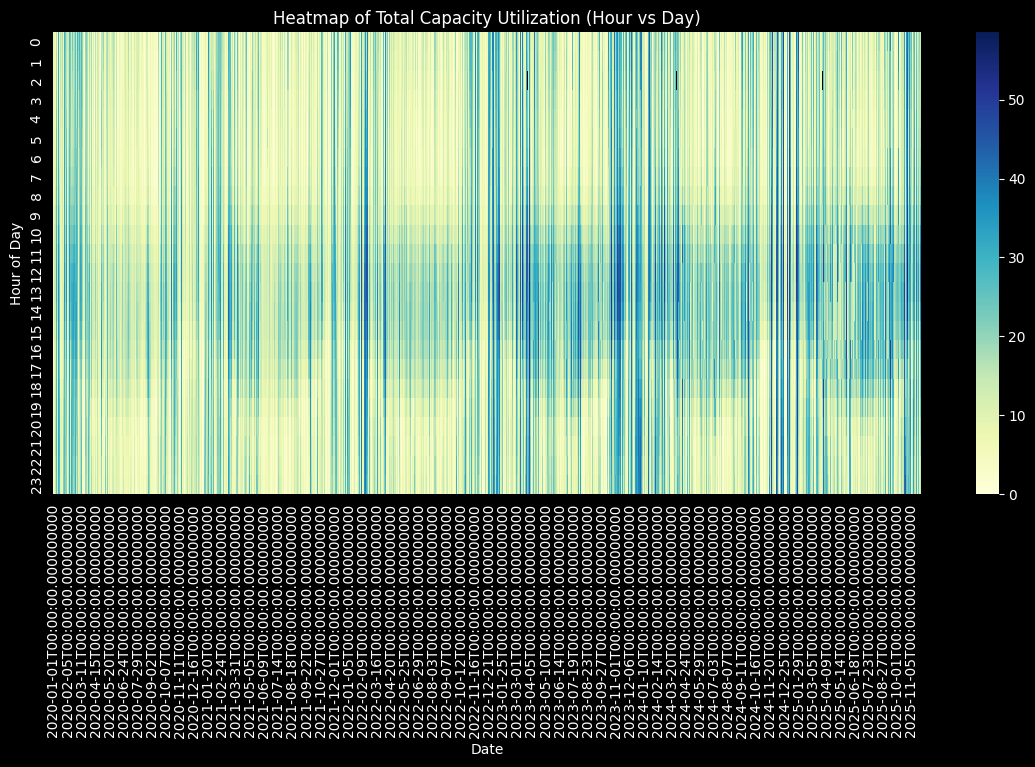

In [40]:
# Pivot for heatmap
heatmap_util = df_pivot.pivot_table(index='Start_Hour', columns='Date', values='Total_util', aggfunc='mean')

sns.heatmap(heatmap_util, cmap="YlGnBu")
plt.title("Heatmap of Total Capacity Utilization (Hour vs Day)")
plt.xlabel("Date")
plt.ylabel("Hour of Day")
plt.show()

### **2️⃣ Risk Analysis: High Uncertainty / Low Reliability**

#### **Step 1: Hourly Variability**

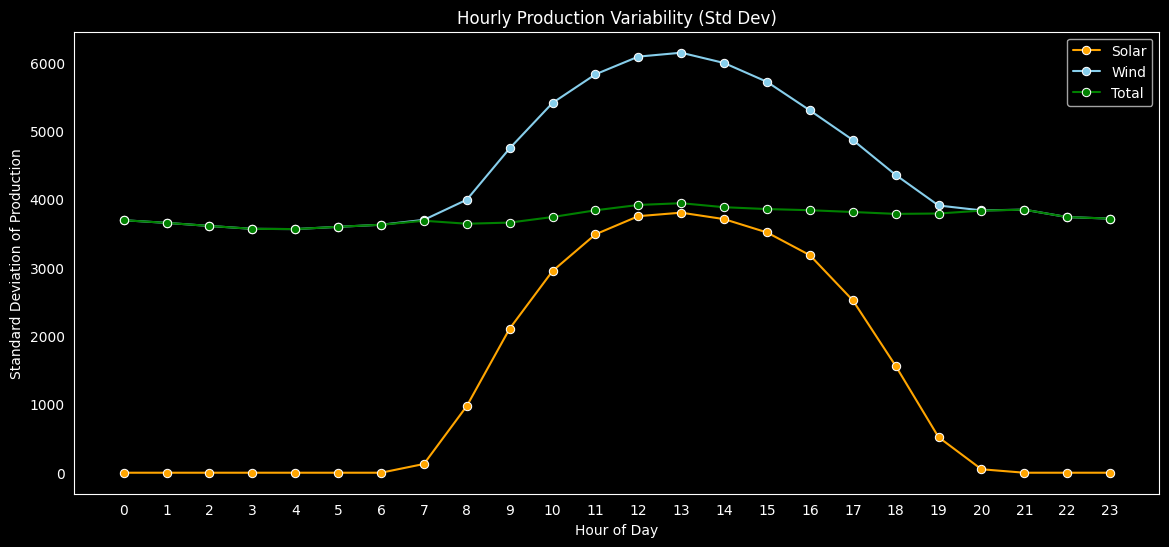

In [41]:
hourly_std = df_pivot.groupby('Start_Hour')[['Solar','Wind','Total_Production']].std().reset_index()

sns.lineplot(data=hourly_std, x='Start_Hour', y='Solar', label='Solar', color='orange', marker='o')
sns.lineplot(data=hourly_std, x='Start_Hour', y='Wind', label='Wind', color='skyblue', marker='o')
sns.lineplot(data=hourly_std, x='Start_Hour', y='Total_Production', label='Total', color='green', marker='o')
plt.title("Hourly Production Variability (Std Dev)")
plt.xlabel("Hour of Day")
plt.ylabel("Standard Deviation of Production")
plt.xticks(range(0,24,1))
plt.show()

#### **Step 2: Low Reliability Periods**

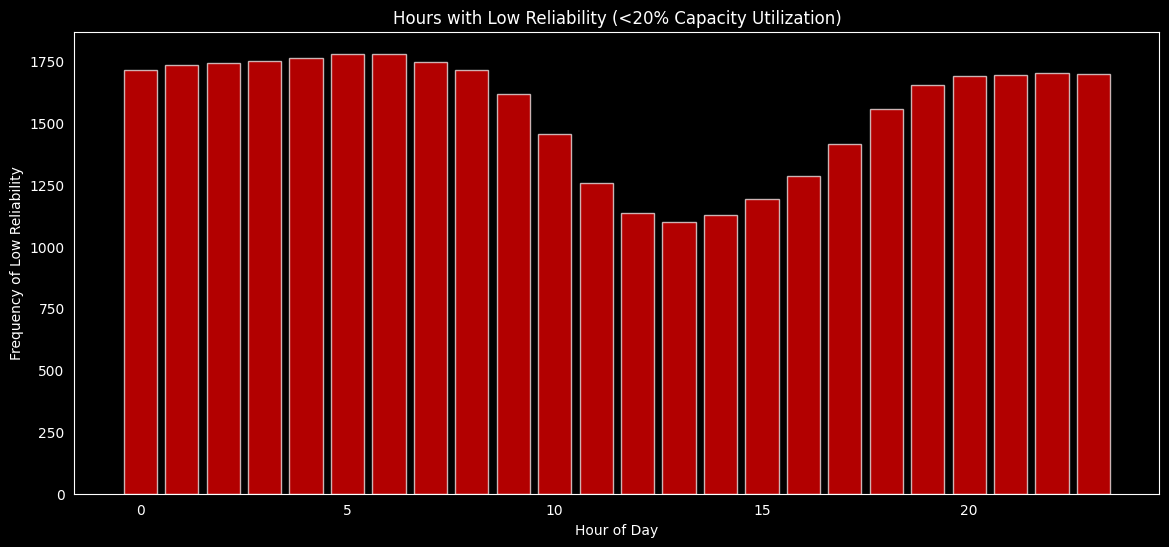

In [42]:
# Define low reliability = production < 20% of max capacity
low_reliability = df_pivot[df_pivot['Total_util'] < 20]

# Count hours of low reliability
low_rel_count = low_reliability.groupby('Start_Hour').size()

plt.bar(low_rel_count.index, low_rel_count.values, color='red', alpha=0.7)
plt.title("Hours with Low Reliability (<20% Capacity Utilization)")
plt.xlabel("Hour of Day")
plt.ylabel("Frequency of Low Reliability")
plt.show()

#### **Step 3: Hybrid Energy Strategy Recommendation (Visual)**

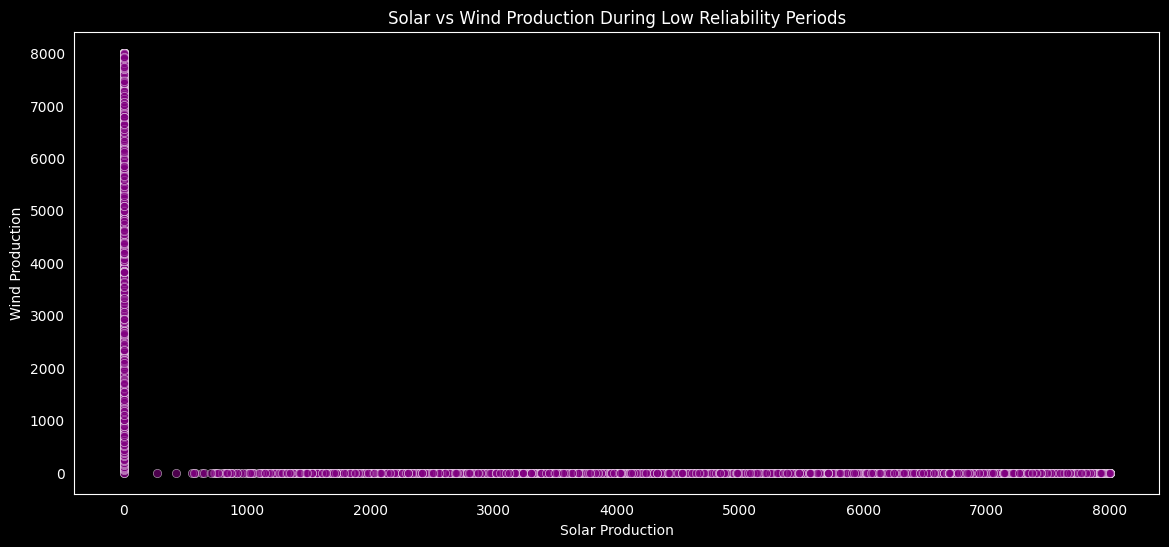

In [43]:
# Scatter: Solar vs Wind during low total utilization periods
sns.scatterplot(data=low_reliability, x='Solar', y='Wind', alpha=0.6, color='purple')
plt.title("Solar vs Wind Production During Low Reliability Periods")
plt.xlabel("Solar Production")
plt.ylabel("Wind Production")
plt.show()

# **7️⃣ Data Quality & Integrity Checks 🧹 (Must-Have)**

### **1️⃣ Duplicate Timestamps**

Duplicate entries: 6


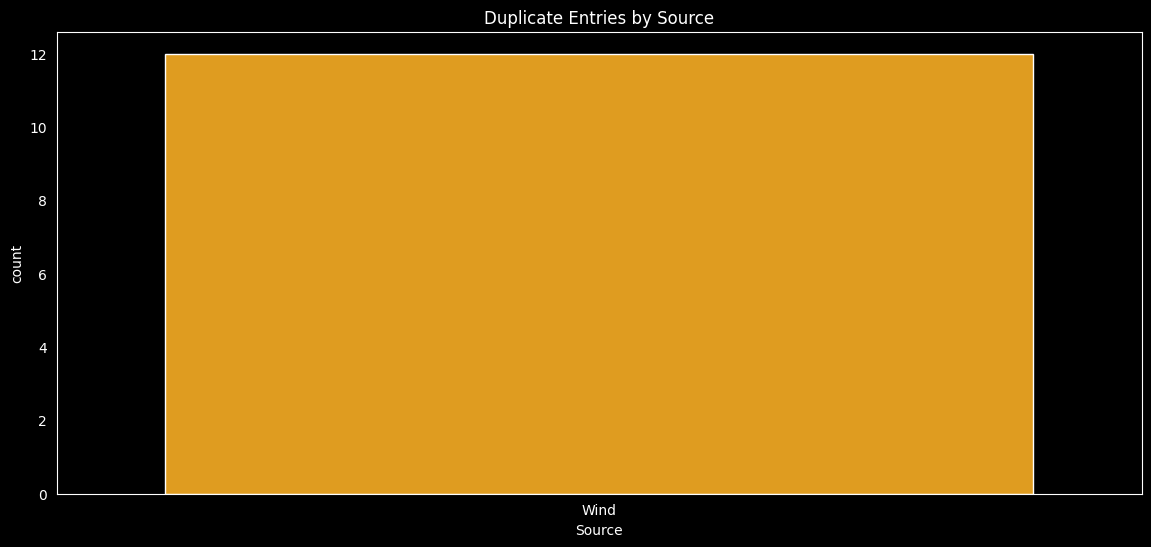

In [44]:
# Count duplicate timestamps
duplicates = df.duplicated(subset=['Date','Start_Hour','End_Hour','Source']).sum()
print(f"Duplicate entries: {duplicates}")

# Plot duplicates by source
dup_counts = df[df.duplicated(subset=['Date','Start_Hour','End_Hour','Source'], keep=False)]
sns.countplot(data=dup_counts, x='Source', palette=['orange','skyblue'])
plt.title("Duplicate Entries by Source")
plt.show()

### **2️⃣ Missing Time Continuity**

#### **Step 1: Generate expected timestamps**

In [45]:
# Create full datetime + hour sequence
df['DateHour'] = pd.to_datetime(df['Date']) + pd.to_timedelta(df['Start_Hour'], unit='h')
full_index = pd.date_range(start=df['DateHour'].min(), end=df['DateHour'].max(), freq='H')

# Find missing hours
missing_hours = full_index.difference(df['DateHour'])
print(f"Missing hours: {len(missing_hours)}")


Missing hours: 6


#### **Step 2: Plot Missing Hours Over Time**

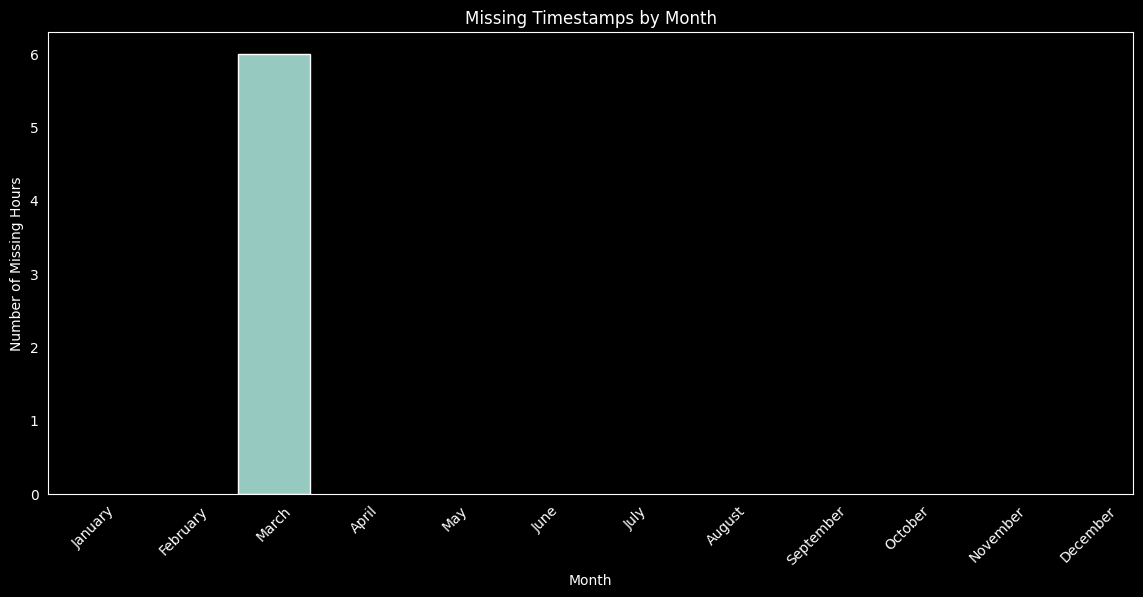

In [46]:
missing_df = pd.DataFrame({'Missing': pd.Series(missing_hours)})
missing_df['Month'] = missing_df['Missing'].dt.month_name()

sns.countplot(data=missing_df, x='Month', order=df['Month_Name'].cat.categories)
plt.title("Missing Timestamps by Month")
plt.xticks(rotation=45)
plt.ylabel("Number of Missing Hours")
plt.show()


### **3️⃣ Impossible Values**

#### **Step 1: Negative Production**

In [47]:
neg_values = df_pivot[(df_pivot[sources] < 0).any(axis=1)]
print(f"Negative production entries: {len(neg_values)}")

if len(neg_values) > 0:
    sns.heatmap(neg_values[sources].replace({0:np.nan}), annot=True, cmap='Reds', cbar=False)
    plt.title("Negative Production Values (Impossible Entries)")
    plt.show()
else:
    print("No negative production values found. Dataset looks clean in this regard.")


Negative production entries: 0
No negative production values found. Dataset looks clean in this regard.


#### **Step 2: Solar Production at Night**

Solar production during night: 104


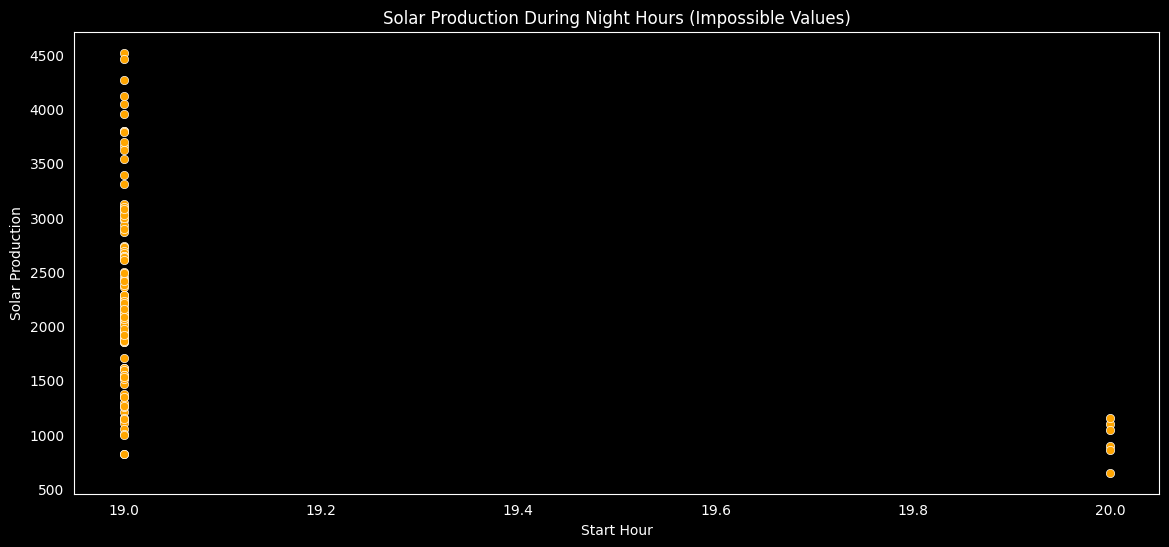

In [48]:
solar_night = df_pivot[(df_pivot['Solar'] > 0) & ((df_pivot['Start_Hour'] < 5) | (df_pivot['End_Hour'] > 19))]
print(f"Solar production during night: {len(solar_night)}")

sns.scatterplot(data=solar_night, x='Start_Hour', y='Solar', color='orange')
plt.title("Solar Production During Night Hours (Impossible Values)")
plt.xlabel("Start Hour")
plt.ylabel("Solar Production")
plt.show()


### **4️⃣ Date Parsing & Consistency**

Date column types:
 Date
<class 'pandas._libs.tslibs.timestamps.Timestamp'>    51864
Name: count, dtype: int64


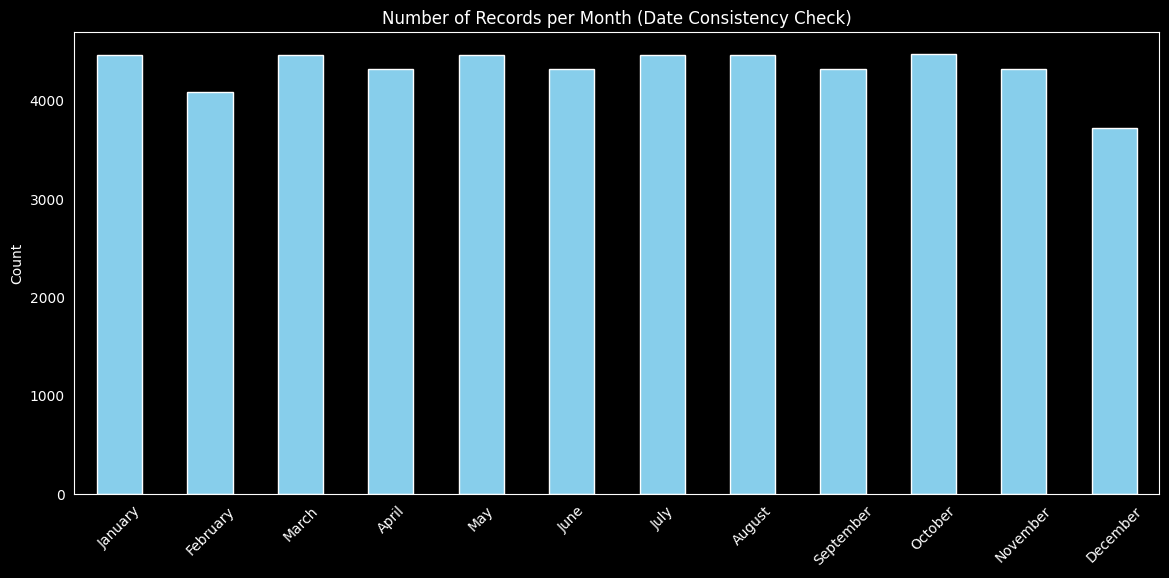

In [49]:
# Check if Date column is consistent
date_types = df['Date'].apply(lambda x: type(x)).value_counts()
print("Date column types:\n", date_types)

# Plot number of entries per month to detect inconsistencies
monthly_counts = df.groupby('Month_Name').size().reindex(df['Month_Name'].cat.categories)

monthly_counts.plot(kind='bar', color='skyblue')
plt.title("Number of Records per Month (Date Consistency Check)")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()

## **Thank You**

Thank you for going through this notebook!  

I hope this analysis provides **valuable insights into Wind and Solar energy production** and demonstrates how **data science can guide operational decisions, policy planning, and renewable energy optimization**.  

Feedback, suggestions, or questions are always welcome — your input helps improve the analysis and fosters a collaborative learning environment.  

Stay curious and keep exploring the power of data! 🌱⚡
